In this mini project, I'm going to answer some business questions by using SQL. I will be using sqlite3 along with pandas library to interact with the database. 

First, let's define some helper functions to save some time during the project:
- `run_query` function returns dataframe produced by pandas. The advantage of dataframe outputs is that they will display as tables in Jupyter notebook.
- `run_command` function will execute some command queries like `CREATE TABLE` without returning anything.
- `show_tables` function will return the tables and views from the database. This is handy to quickly check the state of our database as we work.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    query = """
        SELECT 
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table", "view");
    """
    return run_query(query)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

Let's imagine some artists came to us to sign their albums to be added to our record store, and those artists are from USA. I want to figure out which genres sell the best in the USA so that I can make a recommendation for artists whose albums I should purchase for the store.

In [2]:
query = """
    WITH 
        invoices_usa AS (
            SELECT 
                i.invoice_id,
                c.country
            FROM invoice i
            INNER JOIN customer c ON c.customer_id = i.customer_id
            WHERE c.country = "USA"
        ),
        invoice_lines_usa AS (
            SELECT 
                il.invoice_line_id,
                iu.invoice_id,
                il.track_id,
                iu.country
            FROM invoice_line il
            INNER JOIN invoices_usa iu ON iu.invoice_id = il.invoice_id
        ),
        genre_count_usa AS (
            SELECT 
                g.name AS genre,
                COUNT(t.genre_id) AS abs_num
            FROM track t
            LEFT JOIN genre g ON g.genre_id = t.genre_id
            INNER JOIN invoice_lines_usa ilu ON ilu.track_id = t.track_id
            GROUP BY t.genre_id
        )
    
    SELECT
        genre,
        abs_num AS track_sold,
        ROUND(
            ((CAST(abs_num AS FLOAT)/(SELECT SUM(abs_num) FROM genre_count_usa)) * 100 ), 
            2
        ) AS percentage_sold
    FROM genre_count_usa
    ORDER BY abs_num DESC;
"""

run_query(query)

,genre,track_sold,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


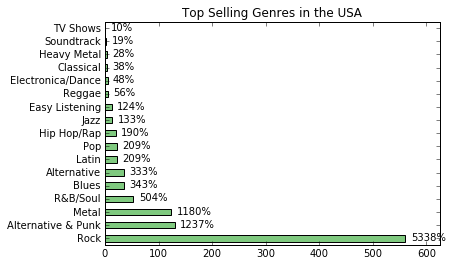

In [3]:
genre_sales_usa = run_query(query)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["track_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "track_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

As a result, the top 3 genres in USA are Rock, Alternative & Punk and Metal.

I used `WITH` clause to store couple of subqueries in order to make the query more readable and maintainable. The first subquery was created to find all invoices from USA. The second subquery was created to find the invoice lines for each track from USA. Then, third subquery was created to find the number of sold tracks for each genre. Lastly, based on the number of sold tracks for each genre I could calculate the percentage of them.

## Analysing Employee Sales Performance

Each customer of our store gets assigned to a sales support agent within the company when they first make a purchase. Imagine I've been asked to analyse the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [4]:
command = """
DROP VIEW employee_customer_view;
"""
run_command(command)

command = """
CREATE VIEW employee_customer_view AS
SELECT
    e.employee_id,
    e.first_name || " " || e.last_name AS employee_name,
    e.title,
    c.customer_id,
    c.first_name || " " || c.last_name AS customer_name
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id;
"""

run_command(command)

In [5]:
query = """
WITH employee_sales_amount AS (
    SELECT 
        ecv.employee_name, 
        SUM(i.total) AS total_sales_amount
    FROM employee_customer_view ecv
    INNER JOIN invoice i ON i.customer_id = ecv.customer_id
    GROUP BY ecv.employee_id
)

SELECT 
    *,
    CASE
        WHEN total_sales_amount > (SELECT AVG(total_sales_amount) FROM employee_sales_amount) THEN 'Overperform'
        ELSE 'Underperform'
    END AS 'performance'
FROM employee_sales_amount
ORDER BY total_sales_amount DESC;
"""

run_query(query)

,employee_name,total_sales_amount,performance
0,Jane Peacock,1731.51,Overperform
1,Margaret Park,1584.00,Overperform
2,Steve Johnson,1393.92,Underperform


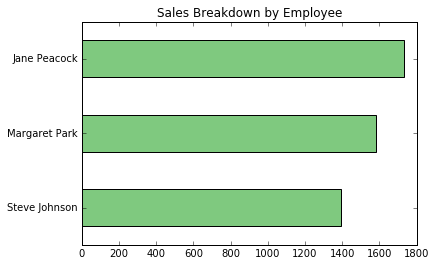

In [6]:
employee_sales = run_query(query)

employee_sales.set_index("employee_name", drop=True, inplace=True)
employee_sales.sort_values("total_sales_amount", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

I created a view for storing data to show sales agenet employees for each customer. I could join invoice table with the view in order to get the dollar amount of each customer spent so that I can use for calculating sum of sales amount for each employee. Then I used the average amount to indicate each employee's performance - who sales more than average is overperforming, otherwise, underperforming.

## Analysing Sales by Country

My next task is to analyse the sales data for customers from each different country. 

I will calculate these for each country:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, I should group these customers as "Other" in the analysis and I will force "Other" to the bottom of the results. 

In [7]:
command = """
DROP VIEW IF EXISTS country_sales_count_view;
"""
run_command(command)

command = """
CREATE VIEW country_sales_count_view AS 
SELECT
    c.country,
    COUNT(c.customer_id) total_customer_count
FROM customer c
GROUP BY c.country;
"""
run_command(command)

query = """
SELECT *
FROM country_sales_count_view;
"""
run_query(query)

,country,total_customer_count
0,Argentina,1
1,Australia,1
2,Austria,1
3,Belgium,1
4,Brazil,5
5,Canada,8
6,Chile,1
7,Czech Republic,2
8,Denmark,1
9,Finland,1


In [8]:
command = """
DROP VIEW IF EXISTS country_total_sales_view;
"""
run_command(command)

command = """
CREATE VIEW country_total_sales_view AS
SELECT
    CASE
        WHEN COUNT(c.customer_id) = 1 THEN 'Other'
        ELSE c.country
    END country,
    COUNT(c.customer_id) total_sales_count,
    SUM(i.total) total_sales_value
FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY c.country
"""
run_command(command)

query = """
SELECT *
FROM country_total_sales_view;
"""
run_query(query)

,country,total_sales_count,total_sales_value
0,Argentina,5,39.60
1,Australia,10,81.18
2,Austria,9,69.30
3,Belgium,7,60.39
4,Brazil,61,427.68
5,Canada,76,535.59
6,Chile,13,97.02
7,Czech Republic,30,273.24
8,Denmark,10,37.62
9,Finland,11,79.20


In [9]:
query = """
WITH 
    country_only_one_customer AS (
        SELECT country
        FROM country_sales_count_view
        WHERE total_customer_count = 1
    ),
    country_customer_count AS (
        SELECT 
            CASE 
                WHEN 
                    country IN (SELECT * FROM country_only_one_customer) 
                    THEN 'Other'
                ELSE country
            END country,
            total_customer_count customer_count
        FROM country_sales_count_view
    ),
    country_customer_count_other_combine AS (
        SELECT 
            country,
            SUM(customer_count) customer_count,
            CASE
                WHEN country = 'Other' THEN 1
                ELSE 0
            END sort
        FROM country_customer_count
        GROUP BY country
    ),
    country_customer_sales AS (
        SELECT 
            CASE
                WHEN country IN (SELECT * FROM country_only_one_customer)
                THEN 'Other'
                ELSE country
            END country,
            total_sales_count sales_count,
            total_sales_value sales_value
        FROM country_total_sales_view           
    ),
    country_customer_sales_other_combined AS (
        SELECT
            country,
            SUM(sales_count) sales_count,
            SUM(sales_value) sales_value,
            CASE
                WHEN country = 'Other' THEN 1
                ELSE 0
            END sort
        FROM country_customer_sales
        GROUP BY country
    )

SELECT 
    ccsoc.country,
    cccoc.customer_count total_customer_count,
    ccsoc.sales_value total_sales_value,
    ROUND(ccsoc.sales_value / ccsoc.sales_count, 2) AS avg_order_value,
    ROUND(ccsoc.sales_value / cccoc.customer_count, 2) AS avg_sales_value_per_c
FROM country_customer_sales_other_combined ccsoc
INNER JOIN country_customer_count_other_combine cccoc ON cccoc.country = ccsoc.country
ORDER BY cccoc.sort, ccsoc.sales_count DESC;
"""

run_query(query)

,country,total_customer_count,total_sales_value,avg_order_value,avg_sales_value_per_c
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,Czech Republic,2,273.24,9.11,136.62
6,Portugal,2,185.13,6.38,92.57
7,United Kingdom,3,245.52,8.77,81.84
8,India,2,183.15,8.72,91.57
9,Other,15,1094.94,7.45,73.00


I got the results of each calculation for each country:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In order to improve readability, I created views (`country_sales_count_view` & `country_total_sales_view`)for total customer count and total sales count & value for each country. 

By using those views, I could easily create subqueries to combine all countries having only one customer to "Other". 

Once I got the table with countries and other, I calculated the total and average sales for each country.

## Albums vs Individual Tracks

Let's say the store management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

I need to find out what percentage of purchases are individual tracks vesus whole albums, so that management can use this data to understand the effect this decision might have on overall revenue. 

In order to answer the question, I'm going to have to identify whether each invoice has all the tracks from an album. I can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album.


In [10]:
command = """
DROP VIEW IF EXISTS album_tracks_view;
"""
run_command(command)

command = """
CREATE VIEW album_tracks_view AS
SELECT 
    a.album_id,
    a.title album_title,
    t.track_id,
    t.name track_name
FROM album a
LEFT JOIN track t ON t.album_id = a.album_id;
"""
run_command(command)

query = """
SELECT *
FROM album_tracks_view;
"""
run_query(query)

,album_id,album_title,track_id,track_name
0,1,For Those About To Rock We Salute You,1,For Those About To Rock (We Salute You)
1,1,For Those About To Rock We Salute You,6,Put The Finger On You
2,1,For Those About To Rock We Salute You,7,Let's Get It Up
3,1,For Those About To Rock We Salute You,8,Inject The Venom
4,1,For Those About To Rock We Salute You,9,Snowballed
5,1,For Those About To Rock We Salute You,10,Evil Walks
6,1,For Those About To Rock We Salute You,11,C.O.D.
7,1,For Those About To Rock We Salute You,12,Breaking The Rules
8,1,For Those About To Rock We Salute You,13,Night Of The Long Knives
9,1,For Those About To Rock We Salute You,14,Spellbound


I created a view called `album_tracks_view` in order to store the list of tracks for each album so that we can see which tracks the albums have.

In [33]:
sub_query = """
WITH 
    album_tracks AS (
        SELECT 
            album_id,
            track_id
        FROM track
        ORDER BY album_id
    ),
    invoice_album_tracks AS (
        SELECT
            i.invoice_id,
            t.album_id,
            t.track_id
        FROM invoice i
        INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
        INNER JOIN track t ON t.track_id = il.track_id
        ORDER BY i.invoice_id
    ),
    invoice_no_album AS (
        SELECT *
        FROM (
            SELECT
                iat.invoice_id,
                CASE
                    WHEN
                        (
                            SELECT track_id
                            FROM album_tracks_view
                            WHERE album_id = iat.album_id

                            EXCEPT

                            SELECT track_id
                            FROM invoice_album_tracks
                            WHERE invoice_id = iat.invoice_id
                            AND album_id = iat.album_id
                        ) IS NULL
                        AND
                        (
                            SELECT track_id
                            FROM invoice_album_tracks
                            WHERE invoice_id = iat.invoice_id
                            AND album_id = iat.album_id

                            EXCEPT

                            SELECT track_id
                            FROM album_tracks_view
                            WHERE album_id = iat.album_id
                        ) IS NULL
                    THEN "yes"
                    ELSE "no"
                END album_contain
            FROM invoice_album_tracks iat
            GROUP BY invoice_id, album_contain
        )
        WHERE album_contain = "no"
    ),
    invoice_containing_album AS (
        SELECT *
        FROM (
            SELECT
                iat.invoice_id,
                CASE
                    WHEN
                        (
                            SELECT track_id
                            FROM album_tracks_view
                            WHERE album_id = iat.album_id

                            EXCEPT

                            SELECT track_id
                            FROM invoice_album_tracks
                            WHERE invoice_id = iat.invoice_id
                            AND album_id = iat.album_id
                        ) IS NULL
                        AND
                        (
                            SELECT track_id
                            FROM invoice_album_tracks
                            WHERE invoice_id = iat.invoice_id
                            AND album_id = iat.album_id

                            EXCEPT

                            SELECT track_id
                            FROM album_tracks_view
                            WHERE album_id = iat.album_id
                        ) IS NULL
                    THEN "yes"
                    ELSE "no"
                END album_contain
            FROM invoice_album_tracks iat
            GROUP BY invoice_id, album_contain
        )
        WHERE album_contain = "yes"
    ),
    invoice_album_only AS (
        SELECT *
        FROM invoice_containing_album
        WHERE invoice_id NOT IN (
            SELECT invoice_id
            FROM invoice_no_album

            INTERSECT

            SELECT invoice_id
            FROM invoice_containing_album
        )
    )
"""

query = sub_query + """
SELECT invoice_id
FROM invoice_album_only
"""
run_query(query)

,invoice_id
0,1
1,5
2,23
3,24
4,31
5,32
6,44
7,46
8,52
9,54


Since we know the list of tracks in the each album, we can identify if each invoice contain the whole tracks of an album or not. I used `EXCEPT` clause to figure out if all the tracks from the first statement are contained in the second statement, and reversed the first and second statement. If both are returning `NULL` I can say the invoice contains whole tracks from an album.

Some invoices might be containing whole tracks from multiple albums. To see the invoices containing both album and individual tracks, I used `INTERSECT` clause between `invoice_no_album` and `invoice_containing_album`. It shows the list of invoice ids we should disregard from the `invoice_containing_album` subquery. 

Once I got the list of the invoices only containing albums, I could answer the business questions by calculating those values.

In [34]:
query = sub_query + """
SELECT 
    CASE
        WHEN iao.album_contain = 'yes' THEN iao.album_contain
        ELSE 'no'
    END AS album_purchase,
    COUNT(i.invoice_id) AS num_of_invoices,
    (CAST(COUNT(i.invoice_id) AS FLOAT) / (
        SELECT COUNT(invoice_id)
        FROM invoice
    ) * 100) AS percentage_of_invoices
FROM invoice i
LEFT JOIN invoice_album_only iao ON iao.invoice_id = i.invoice_id
GROUP BY iao.album_contain
"""
run_query(query)

,album_purchase,num_of_invoices,percentage_of_invoices
0,no,500,81.433225
1,yes,114,18.566775
